# Load Dependencies

In [54]:
import pandas as pd
import numpy as np
from drfp import DrfpEncoder
from scipy.stats import pearsonr
import xgboost as xgb
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [55]:
tmp_df = pd.read_csv('../Data/data1/data1.csv')
lig_smiles = np.array(tmp_df['Ligand'].to_list())
add_smiles =  np.array(tmp_df['Additive'].to_list())
base_smiles =  np.array(tmp_df['Base'].to_list())
ar_ha_smiles =  np.array(tmp_df['Aryl halide'].to_list())
labels =  np.array(tmp_df['Output'].to_list())
labels_std = (labels - labels.min())/(labels.max()-labels.min())
lig_smi_set = list(set(lig_smiles))
add_smi_set = list(set(add_smiles))
base_smi_set = list(set(base_smiles))
ar_ha_smi_set = list(set(ar_ha_smiles))
ar_smi_set=ar_ha_smi_set
lig_smi_set.sort()
add_smi_set.sort()
base_smi_set.sort()
ar_ha_smi_set.sort()

# Generate Descriptor

In [4]:
tem_react=[]
for i in ar_ha_smi_set:
    tem_react.append('NC1=CC=C(C)C=C1'+'.'+i+'>>')

In [56]:
tem_react=['NC1=CC=C(C)C=C1.BrC1=CC=C(C(F)(F)F)C=C1>>FC(F)(F)C(C=C1)=CC=C1NC2=CC=C(C)C=C2',
 'NC1=CC=C(C)C=C1.BrC1=CC=C(CC)C=C1>>CCC(C=C1)=CC=C1NC2=CC=C(C)C=C2',
 'NC1=CC=C(C)C=C1.BrC1=CC=C(OC)C=C1>>COC(C=C1)=CC=C1NC2=CC=C(C)C=C2',
 'NC1=CC=C(C)C=C1.BrC1=CN=CC=C1>>CC(C=C1)=CC=C1NC2=CN=CC=C2',
 'NC1=CC=C(C)C=C1.BrC1=NC=CC=C1>>CC(C=C1)=CC=C1NC2=NC=CC=C2',
 'NC1=CC=C(C)C=C1.ClC1=CC=C(C(F)(F)F)C=C1>>FC(F)(F)C(C=C1)=CC=C1NC2=CC=C(C)C=C2',
 'NC1=CC=C(C)C=C1.ClC1=CC=C(CC)C=C1>>CCC(C=C1)=CC=C1NC2=CC=C(C)C=C2',
 'NC1=CC=C(C)C=C1.ClC1=CC=C(OC)C=C1>>COC(C=C1)=CC=C1NC2=CC=C(C)C=C2',
 'NC1=CC=C(C)C=C1.ClC1=CN=CC=C1>>CC(C=C1)=CC=C1NC2=CN=CC=C2',
 'NC1=CC=C(C)C=C1.ClC1=NC=CC=C1>>CC(C=C1)=CC=C1NC2=NC=CC=C2',
 'NC1=CC=C(C)C=C1.IC1=CC=C(C(F)(F)F)C=C1>>FC(F)(F)C(C=C1)=CC=C1NC2=CC=C(C)C=C2',
 'NC1=CC=C(C)C=C1.IC1=CC=C(CC)C=C1>>CCC(C=C1)=CC=C1NC2=CC=C(C)C=C2',
 'NC1=CC=C(C)C=C1.IC1=CC=C(OC)C=C1>>COC(C=C1)=CC=C1NC2=CC=C(C)C=C2',
 'NC1=CC=C(C)C=C1.IC1=CN=CC=C1>>CC(C=C1)=CC=C1NC2=CN=CC=C2',
 'NC1=CC=C(C)C=C1.IC1=NC=CC=C1>>CC(C=C1)=CC=C1NC2=NC=CC=C2']

In [57]:
from drfp import DrfpEncoder
final_react=[]
for i in range(lig_smiles.shape[0]):
    for j in tem_react:
        if j.split('>>')[0]=='NC1=CC=C(C)C=C1.'+ar_ha_smiles[i]:   
            final_react.append(j.split('>>')[0]+'.'+lig_smiles[i]+'.'+add_smiles[i]+'.'+base_smiles[i]+'>>'+j.split('>>')[1])
drfp = np.array(DrfpEncoder.encode(final_react))
len(final_react)

3955

# Training Models

In [65]:
XGB_opt = xgb.XGBRegressor(n_estimators= 100,max_depth=10)     

## Ligand Splitting

In [59]:
train_cat = ['CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[C@@H]4C5)C[C@H](C4)C[C@H]5C3)[C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)C(OC)=CC=C2OC',
 'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C(C)(C)C)C(C)(C)C)C(OC)=CC=C2OC']
test_cat = ['CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C(C)(C)C)C(C)(C)C)C=CC=C2',
            'CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2']

train_index = []
val_index = []
for tmp_idx,tmp_smi in enumerate(lig_smiles):
    if tmp_smi in train_cat:
        train_index.append(tmp_idx)
    elif tmp_smi in test_cat:
        val_index.append(tmp_idx)

In [39]:
model= XGB_opt
all_r2 = []
all_pearsr = []
all_mae = []
all_rmse= []
repeat_pred = []
repeat_test = []
for i in range(10):           
    train_x,test_x = drfp[train_index],drfp[val_index]
    train_y,test_y = labels_std[train_index],labels_std[val_index]
    model.fit(train_x,train_y)
    test_pred = model.predict(test_x)*(labels.max()-labels.min())+labels.min()
    test_y=test_y*(labels.max()-labels.min())+labels.min()
    repeat_pred.append(test_pred)
    repeat_test.append(test_y)
    r2 = r2_score(test_y,test_pred)
    pearsr = pearsonr(test_y,test_pred)
    mae = mean_absolute_error(test_y,test_pred)
    rmse=(mean_squared_error(test_y,test_pred))**(0.5)
    all_r2.append(r2)
    all_pearsr.append(pearsr[0])
    all_mae.append(mae)
    all_rmse.append(rmse)
    

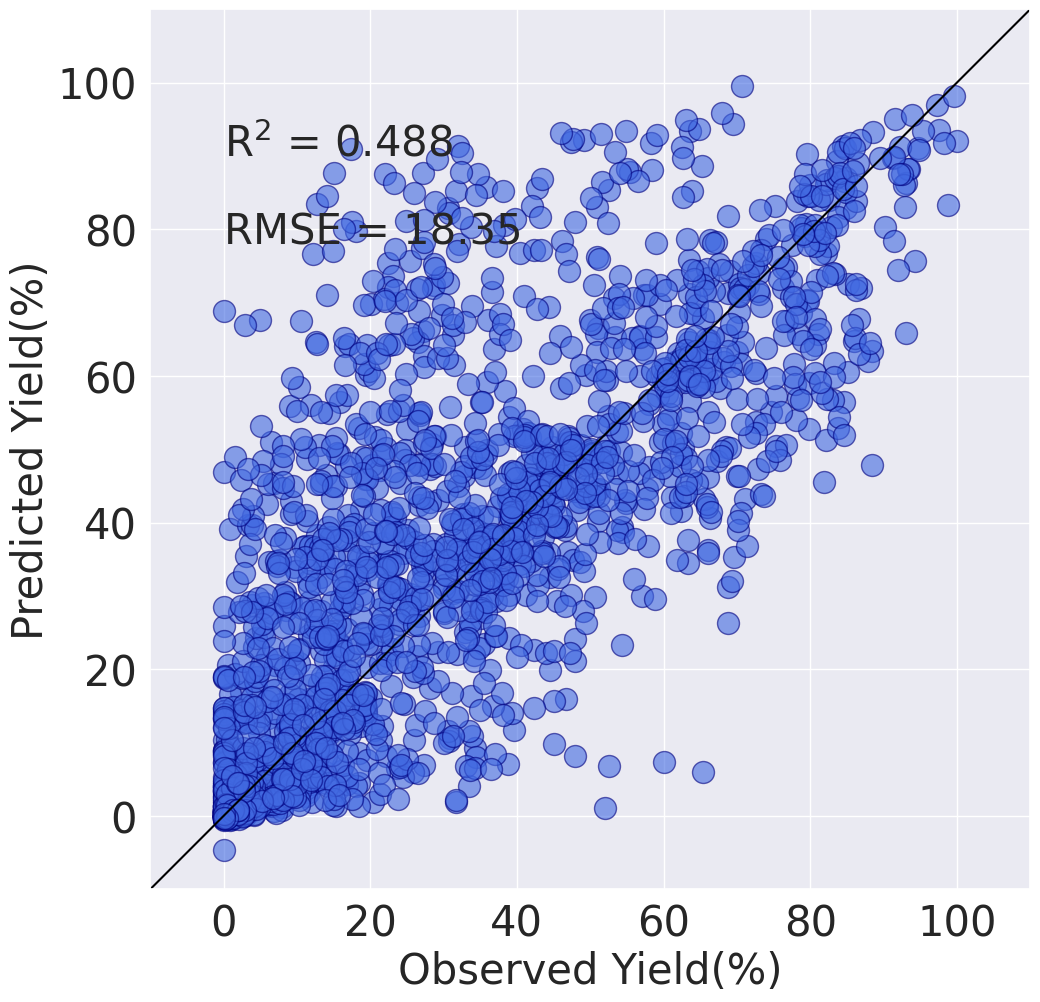

In [40]:
y_val = np.mean(repeat_test,axis=0)
y_pred=np.mean(repeat_pred,axis=0)
np.save('./result/data1_drfp_y_val_lig.npy',y_val)
np.save('./result/data1_drfp_y_pred_lig.npy',y_pred)
sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',    
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')#royalblue
plt.plot([-20,120],[-20,120],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed Yield(%)",fontsize=30)
plt.ylabel("Predicted Yield(%)",fontsize=30)
plt.tick_params(labelsize=30)
plt.text(0,78,'RMSE = %.2f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(0,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

## Aryl Halide Splitting

In [42]:
train_ar_ha = ['IC1=CC=C(C(F)(F)F)C=C1', 'BrC1=CC=C(OC)C=C1', 
             'BrC1=CC=C(C(F)(F)F)C=C1', 'IC1=CC=C(OC)C=C1', 'ClC1=CC=C(CC)C=C1', 'ClC1=CC=C(C(F)(F)F)C=C1', 'BrC1=CC=C(CC)C=C1', 
             'IC1=CC=C(CC)C=C1', 'ClC1=CC=C(OC)C=C1']
test_ar_ha = ['BrC1=CN=CC=C1', 'BrC1=NC=CC=C1', 'IC1=NC=CC=C1', 'IC1=CN=CC=C1', 'ClC1=CN=CC=C1', 'ClC1=NC=CC=C1']

train_index = []
val_index = []
for tmp_idx,tmp_smi in enumerate(ar_ha_smiles):
    if tmp_smi in train_ar_ha:
        train_index.append(tmp_idx)
    elif tmp_smi in test_ar_ha:
        val_index.append(tmp_idx)

In [43]:
model= XGB_opt
all_r2 = []
all_pearsr = []
all_mae = []
all_rmse= []
repeat_pred = []
repeat_test = []
for i in range(10):           
    train_x,test_x = drfp[train_index],drfp[val_index]
    train_y,test_y = labels_std[train_index],labels_std[val_index]
    model.fit(train_x,train_y)
    test_pred = model.predict(test_x)*(labels.max()-labels.min())+labels.min()
    test_y=test_y*(labels.max()-labels.min())+labels.min()
    repeat_pred.append(test_pred)
    repeat_test.append(test_y)
    r2 = r2_score(test_y,test_pred)
    pearsr = pearsonr(test_y,test_pred)
    mae = mean_absolute_error(test_y,test_pred)
    rmse=(mean_squared_error(test_y,test_pred))**(0.5)
    all_r2.append(r2)
    all_pearsr.append(pearsr[0])
    all_mae.append(mae)
    all_rmse.append(rmse)

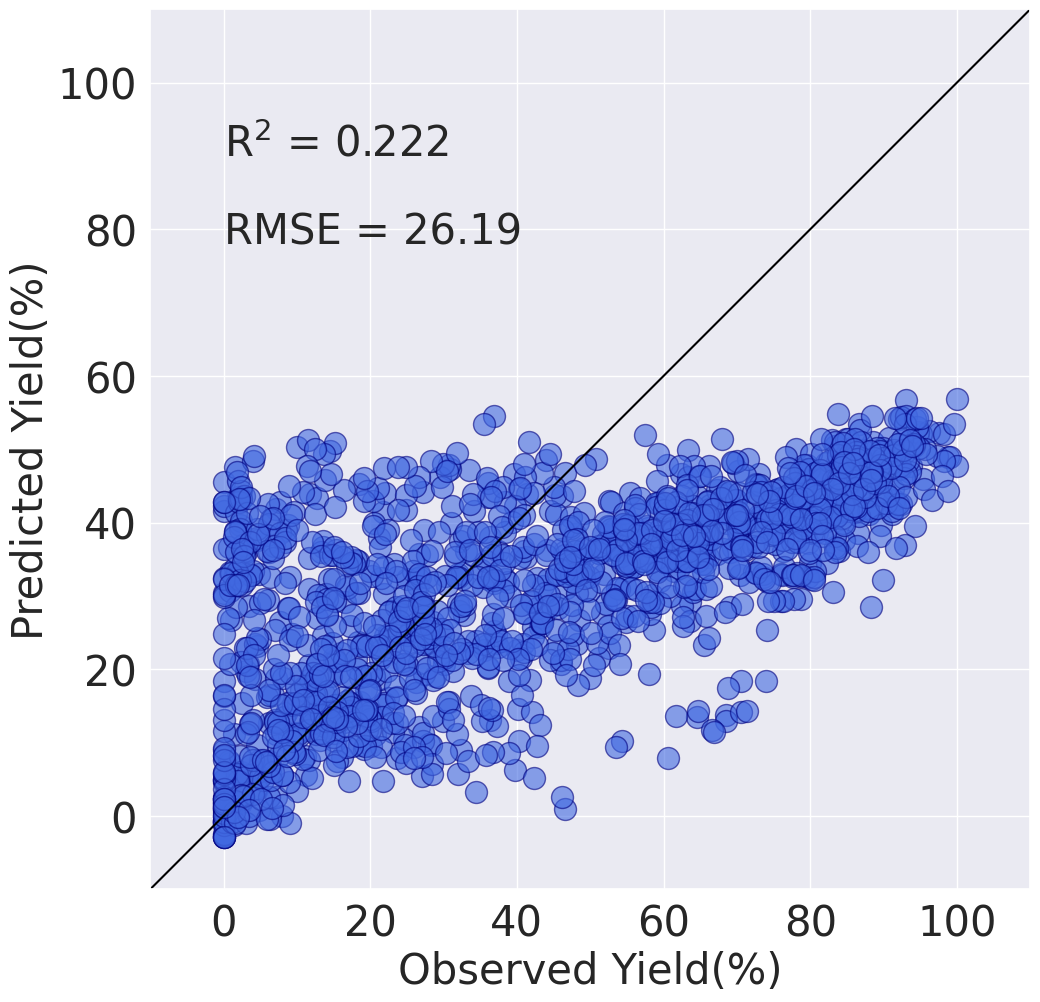

In [44]:
y_val = np.mean(repeat_test,axis=0)
y_pred=np.mean(repeat_pred,axis=0)
np.save('./result/data1_drfp_y_val_ar_ha.npy',y_val)
np.save('./result/data1_drfp_y_pred_ar_ha.npy',y_pred)
sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',    
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')#royalblue
plt.plot([-20,120],[-20,120],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
#ax.set_facecolor('mistyrose')
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed Yield(%)",fontsize=30)
plt.ylabel("Predicted Yield(%)",fontsize=30)
plt.tick_params(labelsize=30)
plt.text(0,78,'RMSE = %.2f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(0,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

## Additive Splitting

In [46]:
train_add = ['CCOC(C1=NOC=C1)=O', 'C1(N(CC2=CC=CC=C2)CC3=CC=CC=C3)=CC=NO1', 'C1(C2=CC=CC=C2)=CC=NO1', 'C1(C2=CC=CC=C2)=NOC=C1',
                'FC(C=CC=C1F)=C1C2=CC=NO2', 'CCOC(C1=CON=C1)=O', 
                'O=C(OC)C1=CC=NO1', 'CC1=NOC=C1', 'CC1=CC=NO1',
                'C1(C2=CC=CC=C2)=CON=C1',
                'C1(N(CC2=CC=CC=C2)CC3=CC=CC=C3)=NOC=C1']
test_add = ['O=C(OC)C1=NOC(C2=CC=CS2)=C1','CC1=NOC(C(OCC)=O)=C1', 'COC1=NOC(C(OCC)=O)=C1', 'CC1=CC(N2C=CC=C2)=NO1','O=C(OC)C1=NOC(C2=CC=CO2)=C1',
              'C12=CON=C1C=CC=C2','C12=C(C=CC=C2)ON=C1', 'CC1=CC(C)=NO1', 'CC1=C(C(OCC)=O)C=NO1', 'CC1=NOC(C2=CC=CC=C2)=C1','CC1=CC(C(OCC)=O)=NO1']

train_index = []
val_index = []
for tmp_idx,tmp_smi in enumerate(add_smiles):
    if tmp_smi in train_add:
        train_index.append(tmp_idx)
    elif tmp_smi in test_add:
        val_index.append(tmp_idx)

In [47]:
model=XGB_opt
all_r2 = []
all_pearsr = []
all_mae = []
all_rmse= []
repeat_pred = []
repeat_test = []
for i in range(10):           
    train_x,test_x = drfp[train_index],drfp[val_index]
    train_y,test_y = labels_std[train_index],labels_std[val_index]
    model.fit(train_x,train_y)
    test_pred = model.predict(test_x)*(labels.max()-labels.min())+labels.min()
    test_y=test_y*(labels.max()-labels.min())+labels.min()
    repeat_pred.append(test_pred)
    repeat_test.append(test_y)
    r2 = r2_score(test_y,test_pred)
    pearsr = pearsonr(test_y,test_pred)
    mae = mean_absolute_error(test_y,test_pred)
    rmse=(mean_squared_error(test_y,test_pred))**(0.5)
    all_r2.append(r2)
    all_pearsr.append(pearsr[0])
    all_mae.append(mae)
    all_rmse.append(rmse)

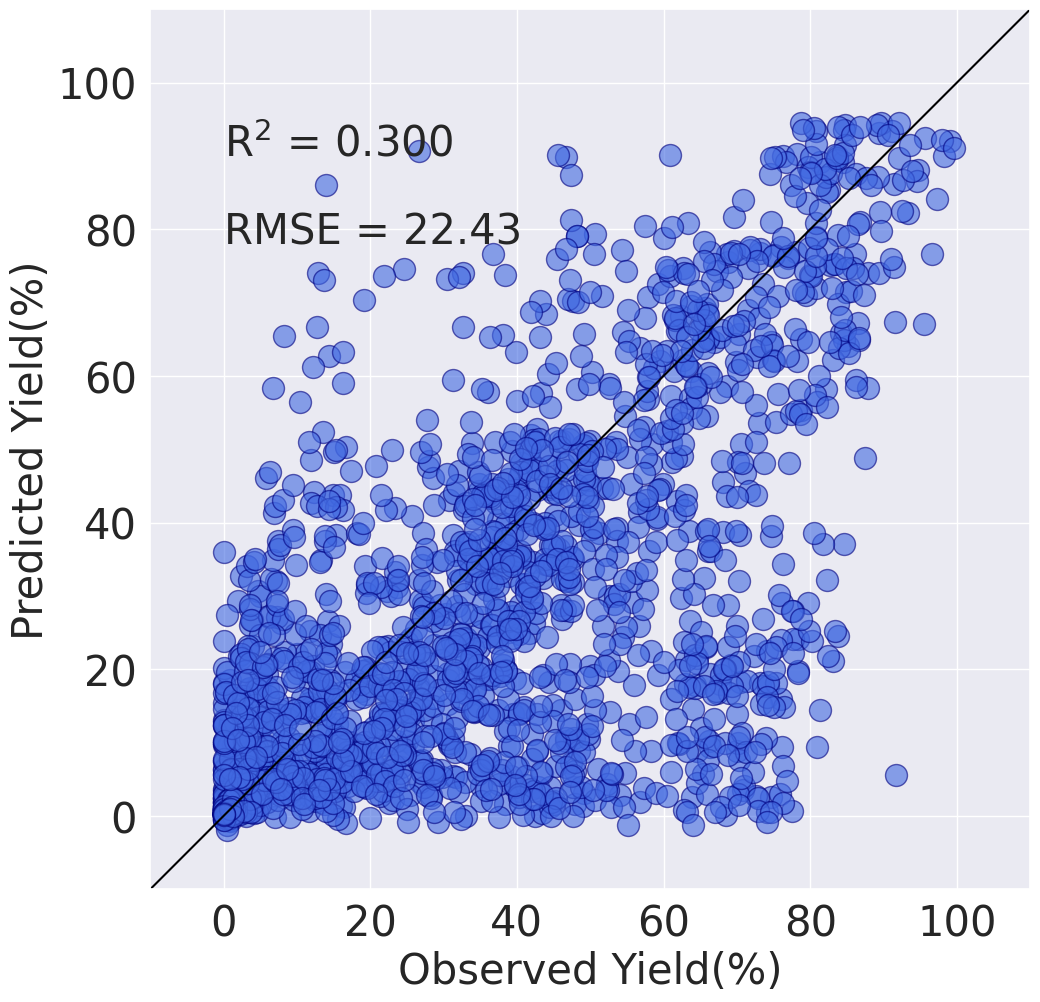

In [48]:
y_val = np.mean(repeat_test,axis=0)
y_pred=np.mean(repeat_pred,axis=0)
np.save('./result/data1_drfp_y_val_add.npy',y_val)
np.save('./result/data1_drfp_y_pred_add.npy',y_pred)
sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',    
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')#royalblue
plt.plot([-20,120],[-20,120],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
#ax.set_facecolor('mistyrose')
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed Yield(%)",fontsize=30)
plt.ylabel("Predicted Yield(%)",fontsize=30)
plt.tick_params(labelsize=30)
plt.text(0,78,'RMSE = %.2f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(0,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

## Base Splitting

In [50]:
train_base = ['CN1CCCN2C1=NCCC2',
 'CC(C)(C)/N=C(N(C)C)/N(C)C']
test_base = ['CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC']

train_index = []
val_index = []
for tmp_idx,tmp_smi in enumerate(base_smiles):
    if tmp_smi in train_base:
        train_index.append(tmp_idx)
    elif tmp_smi in test_base:
        val_index.append(tmp_idx)

In [51]:
model= XGB_opt
all_r2 = []
all_pearsr = []
all_mae = []
all_rmse= []
repeat_pred = []
repeat_test = []
for i in range(10):           
    train_x,test_x = drfp[train_index],drfp[val_index]
    train_y,test_y = labels_std[train_index],labels_std[val_index]
    model.fit(train_x,train_y)
    test_pred = model.predict(test_x)*(labels.max()-labels.min())+labels.min()
    test_y=test_y*(labels.max()-labels.min())+labels.min()
    repeat_pred.append(test_pred)
    repeat_test.append(test_y)
    r2 = r2_score(test_y,test_pred)
    pearsr = pearsonr(test_y,test_pred)
    mae = mean_absolute_error(test_y,test_pred)
    rmse=(mean_squared_error(test_y,test_pred))**(0.5)
    all_r2.append(r2)
    all_pearsr.append(pearsr[0])
    all_mae.append(mae)
    all_rmse.append(rmse)

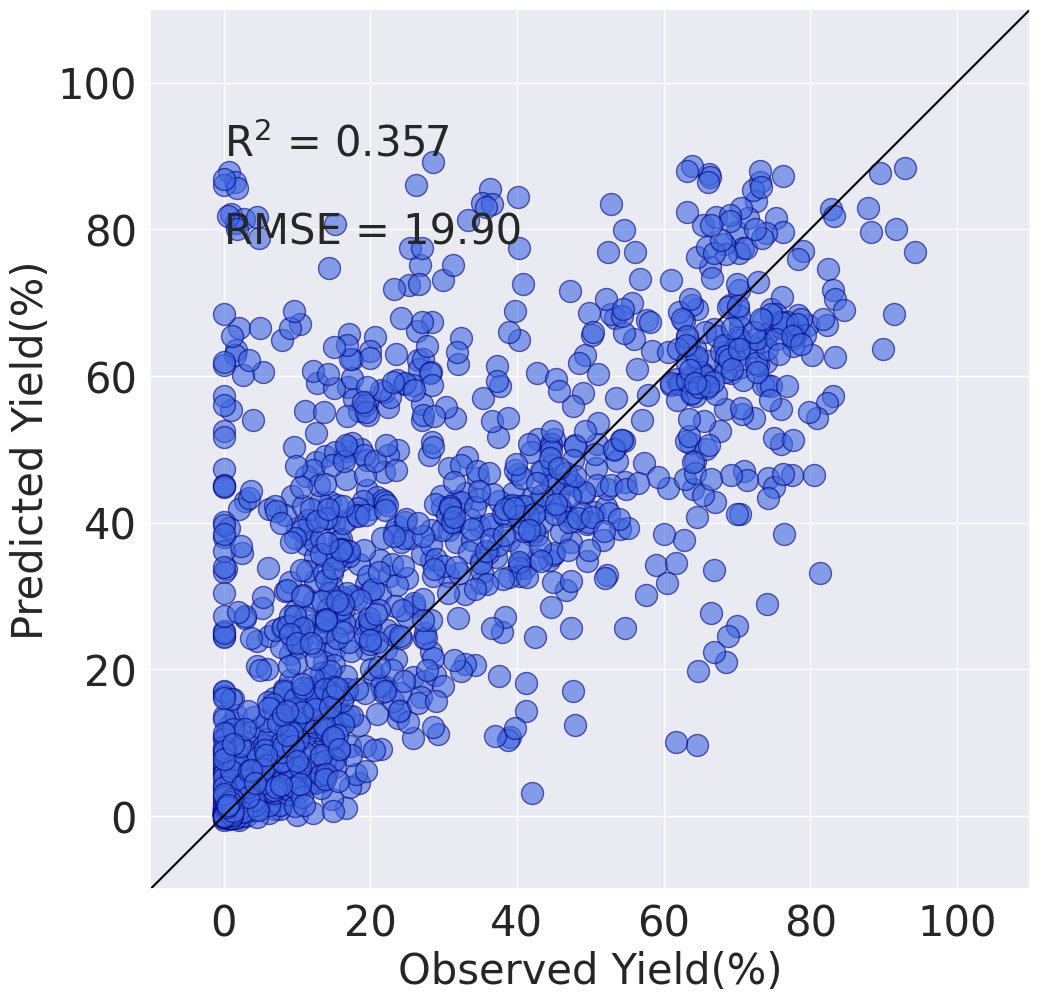

In [52]:
y_val = np.mean(repeat_test,axis=0)
y_pred=np.mean(repeat_pred,axis=0)
np.save('./result/data1_drfp_y_val_base.npy',y_val)
np.save('./result/data1_drfp_y_pred_base.npy',y_pred)
sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',    
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')#royalblue
plt.plot([-20,120],[-20,120],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
#ax.set_facecolor('mistyrose')
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed Yield(%)",fontsize=30)
plt.ylabel("Predicted Yield(%)",fontsize=30)
plt.tick_params(labelsize=30)
plt.text(0,78,'RMSE = %.2f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(0,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()